## Import Library yang dibutuhkan

In [4]:
import re
import joblib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Sklearn
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.calibration import CalibratedClassifierCV
from sklearn.metrics import accuracy_score, f1_score, classification_report
# if use cdist on dense if small:
# from scipy.spatial.distance import cdist
# else:
from sklearn.metrics.pairwise import cosine_similarity

# Multinomial Naive Bayes
from sklearn.naive_bayes import MultinomialNB

# Collections
from collections import Counter

## Load Dataset

In [5]:
df = pd.read_csv("../data/processed/Clean Dataset/cleaned_data.csv")
df.head()

,job_title_clean,job_summary_clean,skills_token,input_text
0,veterinary receptionist,join the adventure at austin bluffs animal cli...,"['veterinary_receptionist', 'aahaaccredited', ...",veterinary receptionist join the adventure at ...
1,travel allied health professional ct technologist,flexcare imaging is seeking a travel ct techno...,"['ct_technologist', 'allied_health_professiona...",travel allied health professional ct technolog...
2,assistant general manager,an assistant general manager is the agms provi...,"['hiring', 'training', 'retaining', 'developin...",assistant general manager an assistant general...
3,internal auditor,details open date 01 10 2024 requisition numbe...,"['accounting', 'auditing', 'gaap', 'tax_laws',...",internal auditor details open date 01 10 2024 ...
4,audit manager,job details description keiter mission help pe...,"['accounting_principles', 'auditing_standards'...",audit manager job details description keiter m...


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 260159 entries, 0 to 260158
Data columns (total 4 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   job_title_clean    260159 non-null  object
 1   job_summary_clean  260159 non-null  object
 2   skills_token       260159 non-null  object
 3   input_text         260159 non-null  object
dtypes: object(4)
memory usage: 7.9+ MB


In [7]:
df.isnull().sum()

job_title_clean      0
job_summary_clean    0
skills_token         0
input_text           0
dtype: int64

## Cek Duplicate Rows

In [8]:
# Cek duplicate berdasarkan input_text (skills + summary)
print("="*80)
print("DUPLICATE ANALYSIS".center(80))
print("="*80)

# Total duplicates
total_duplicates = df["input_text"].duplicated().sum()
print(f"Duplicate Statistics:")
print(f"   - Total duplicates             : {total_duplicates:,}")
print(f"   - Percentage                   : {(total_duplicates/len(df)*100):.2f}%")

# Cek apakah duplicate memiliki job_title yang sama atau beda
duplicated_rows = df[df["input_text"].duplicated(keep=False)]
print(f"   - Total rows with duplicates   : {len(duplicated_rows):,}")

# Apakah duplicate punya label yang sama?
duplicate_check = df[df["input_text"].duplicated(keep=False)].groupby("input_text")["job_title_clean"].nunique()
mixed_labels = (duplicate_check > 1).sum()
print(f"   - Duplicates with MIXED labels : {mixed_labels}")
print(f"   - Duplicates with SAME label   : {len(duplicate_check) - mixed_labels}")

                               DUPLICATE ANALYSIS                               
Duplicate Statistics:
   - Total duplicates             : 0
   - Percentage                   : 0.00%
   - Total rows with duplicates   : 0
   - Duplicates with MIXED labels : 0
   - Duplicates with SAME label   : 0


In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 260159 entries, 0 to 260158
Data columns (total 4 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   job_title_clean    260159 non-null  object
 1   job_summary_clean  260159 non-null  object
 2   skills_token       260159 non-null  object
 3   input_text         260159 non-null  object
dtypes: object(4)
memory usage: 7.9+ MB


## Label Encoding

In [10]:
# Deklarasi variable untuk column "input_text" dan "job_title_clean"
X = df["input_text"].astype(str)
y = df["job_title_clean"].astype(str)

In [11]:
le = LabelEncoder()
y_enc = le.fit_transform(y)
joblib.dump(le, "../models/label_encoder.joblib")
print("Label encoder saved to: ../models/label_encoder.joblib")

Label encoder saved to: ../models/label_encoder.joblib


## Train Test Split

In [12]:
X_train, X_test, y_train, y_test = train_test_split(
    X, 
    y_enc,
    test_size=0.2,
    random_state=42,
    stratify=y_enc
)

print(f"Train size : {len(X_train)}")
print(f"Test size  : {len(X_test)}")

Train size : 208127
Test size  : 52032


## TF-IDF

In [13]:
tfidf = TfidfVectorizer(
    max_features=120000,
    ngram_range=(1, 2),     # unigram + bigram (sangat bagus untuk job description)
    stop_words="english",
    sublinear_tf=True,      # log-scaling -> hasil lebih stabil
    min_df=2,               # Abaikan istilah yang muncul dalam kurang dari 2 dokumen
    max_df=0.95             # Abaikan istilah yang muncul di lebih dari 95% dokumen
)

In [14]:
# Deklarasi variable (transform)
X_train_tfidf = tfidf.fit_transform(X_train)
X_test_tfidf  = tfidf.transform(X_test)

joblib.dump(tfidf, "../models/tfidf_vectorizer.joblib")
print(f"TF-IDF vectorizer saved (features : {X_train_tfidf.shape[1]})")

TF-IDF vectorizer saved (features : 120000)


## Model Training & Evaluation

In [15]:
models = {}

In [16]:
# LinearSVC (fast) -> calibrate for probabilities
svc = LinearSVC(
    max_iter=600,
    random_state=42
)

svc_cal = CalibratedClassifierCV(svc, cv=3, n_jobs=2)
models["svc_cal"] = svc_cal

In [17]:
# Logistic Regression (good baseline, supports predict_proba)
models["logreg"] = LogisticRegression(
    max_iter=600,
    solver='saga',      # Efisien untuk kumpulan data besar
    n_jobs=2,           # gunakan 2 core
    random_state=42,
    verbose=0,
    C=1.0               # Kekuatan regularisasi
)

In [18]:
# 1) Multinomial Naive Bayes
models["mnb"] = MultinomialNB(alpha=0.1)

In [19]:
# TRAIN baseline models
trained_models = {}

print("=" * 80)
print("Training Model".center(80))
print("=" * 80,"\n")

for name in ["svc_cal", "logreg", "mnb"]:
    if name == "svc_cal":
        print("Training : LinearSVC (Calibrated)")
    elif name == "logreg":
        print("Training : Logistic Regression")
    elif name == "mnb":
        print("Training : Multinomial Naive Bayes")
        
    models[name].fit(X_train_tfidf, y_train)
    trained_models[name] = models[name]

                                 Training Model                                 

Training : LinearSVC (Calibrated)
Training : Logistic Regression
Training : Multinomial Naive Bayes


In [20]:
# Evaluation helper
def evaluate_model(model, X_test, y_test, name="model"):
    preds = model.predict(X_test)
    acc = accuracy_score(y_test, preds)
    f1 = f1_score(y_test, preds, average="weighted")
    print("=" * 80)
    print(f"{name}".center(80))
    print("=" * 80)
    print(f"\nAccuracy     : {acc}")
    print(f"Weighted F1  : {f1}\n")
    print(classification_report(y_test, preds, zero_division=0))
    return acc, f1, preds

In [21]:
results = {}

# evaluate
results["svc_cal"] = evaluate_model(
    trained_models["svc_cal"],
    X_test_tfidf,
    y_test,
    "LinearSVC (Calibrated)"
)

results["logreg"] = evaluate_model(
    trained_models["logreg"],
    X_test_tfidf,
    y_test,
    "Logistic Regression"
)

results["mnb"] = evaluate_model(
    trained_models["mnb"],
    X_test_tfidf,
    y_test,
    "Multinomial Naive Bayes"
)

                             LinearSVC (Calibrated)                             

Accuracy     : 0.9706526752767528
Weighted F1  : 0.9704895064622471

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        44
           1       1.00      1.00      1.00        99
           2       1.00      1.00      1.00        95
           3       0.95      0.98      0.96       524
           4       0.93      0.91      0.92       185
           5       0.94      0.93      0.94       312
           6       0.93      0.97      0.95       305
           7       1.00      0.98      0.99        45
           8       0.97      0.98      0.97       117
           9       0.96      0.99      0.98       121
          10       1.00      1.00      1.00        43
          11       1.00      1.00      1.00        48
          12       1.00      1.00      1.00        47
          13       1.00      0.96      0.98        74
          14       0.96      0.96     

## Model Comparison Plot

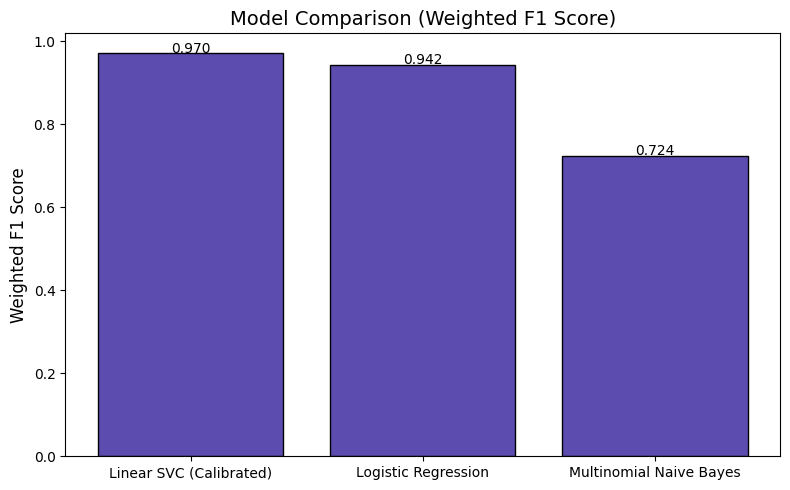

In [22]:
# Mapping nama model
model_name = {
    "svc_cal": "Linear SVC (Calibrated)",
    "logreg": "Logistic Regression",
    "mnb": "Multinomial Naive Bayes"
}

# Ambil nama versi readable
names = [model_name[n] for n in results.keys()]
f1s = [results[n][1] for n in results.keys()]

plt.figure(figsize=(8,5))
plt.bar(names, f1s, color="#5D4CB0", edgecolor="black")
plt.title("Model Comparison (Weighted F1 Score)", fontsize=14)
plt.ylabel("Weighted F1 Score", fontsize=12)

for i, v in enumerate(f1s):
    plt.text(i, v + 0.002, f"{v:.3f}", ha="center", fontsize=10)

plt.xticks(rotation=0)
plt.tight_layout()
plt.show()


## Save Best Model

In [23]:
best_name = max(results, key=lambda k: results[k][1])
best_model = trained_models[best_name]

model_name = {
    "svc_cal": "Linear SVC (Calibrated)",
    "logreg": "Logistic Regression",
    "mnb": "Multinomial Naive Bayes"
}

names = model_name.get(best_name, best_name)
print(f"Selected best model : {names}")

# save best model
joblib.dump(best_model, "../models/best_model.joblib")
print(f"{names} Model successfully saved")
print("Path : ../models/best_model.joblib")

Selected best model : Linear SVC (Calibrated)
Linear SVC (Calibrated) Model successfully saved
Path : ../models/best_model.joblib


## Prediction Function with Confidence & Top K

In [24]:
def predict_with_confidence(text, top_k=3):
    # Basic cleaning
    txt = str(text)
    txt = re.sub(r"http\S+|www\S+", "", txt)
    txt = re.sub(r"[^a-zA-Z ]", " ", txt)
    txt = re.sub(r"\s+", " ", txt).strip().lower()

    # TF-IDF transform
    vec = tfidf.transform([txt])

    # Use model terbaik
    model = best_model

    # Case 1 : model mendukung predict_proba
    if hasattr(model, "predict_proba"):
        proba = model.predict_proba(vec)[0]
        idx = np.argsort(proba)[::-1][:top_k]
        labels = le.inverse_transform(idx)
        scores = proba[idx]
        return list(zip(labels, scores))

    # Case 2: Tidak ada predict_proba (jarang terjadi, misal SVC tanpa calibrate)
    elif hasattr(model, "decision_function"):
        dec = model.decision_function(vec)

        # Multiclass → ambil top-k berdasarkan decision score
        if dec.ndim > 1:
            idx = np.argsort(dec[0])[::-1][:top_k]
            vals = dec[0][idx]

            # Softmax untuk pseudo-probability
            exps = np.exp(vals - np.max(vals))
            scores = exps / exps.sum()

            labels = le.inverse_transform(idx)
            return list(zip(labels, scores))

        # Binary classification fallback
        else:
            prob_pos = 1 / (1 + np.exp(-dec))
            pred = int(model.predict(vec)[0])
            label = le.inverse_transform([pred])[0]
            return [(label, float(prob_pos))]

    # Case 3: Tidak ada informasi probabilitas sama sekali
    else:
        pred = int(model.predict(vec)[0])
        label = le.inverse_transform([pred])[0]
        return [(label, 1.0)]

Example

In [25]:
print(f"Example predictions : {predict_with_confidence("experience with python, sql, aws, data analysis", top_k=3)}")

Example predictions : [('senior data engineer', np.float64(0.5092368081681037)), ('software engineer', np.float64(0.12388828415449367)), ('business analyst', np.float64(0.040651819637409915))]


## SKILL RECOMMENDER

Approach :
- Bangun matriks TF-IDF korpus keterampilan menggunakan skills_token (setiap baris = rangkaian keterampilan pekerjaan)
- Untuk input tertentu (keterampilan pekerjaan atau kandidat), hitung kesamaan kosinus dan kembalikan keterampilan n teratas yang sering muncul di postingan pekerjaan yang paling mirip tetapi tidak dalam input

In [26]:
# cek column "skills_token"
(df["skills_token"].str.len() == 0).sum()

np.int64(0)

In [27]:
def fix_spaced_letters(text):
    # hapus array markup seperti: [ ', ' ]
    text = str(text)

    # remove tanda kutip dan koma
    text = re.sub(r"[\'\,\[\]]", " ", text)

    # collapse multiple spaces
    text = re.sub(r"\s+", " ", text).strip()

    # gabungkan huruf yang terpisah spasi menggunakan regex
    # contoh: "v e t e r i n a r y" -> "veterinary"
    return re.sub(r"(?:\b\w\s){2,}\w\b", lambda m: m.group(0).replace(" ", ""), text)

# Prepare skills_text
df["skills_text"] = df["skills_token"].apply(fix_spaced_letters)

In [28]:
df.head()

,job_title_clean,job_summary_clean,skills_token,input_text,skills_text
0,veterinary receptionist,join the adventure at austin bluffs animal cli...,"['veterinary_receptionist', 'aahaaccredited', ...",veterinary receptionist join the adventure at ...,veterinary_receptionist aahaaccredited custome...
1,travel allied health professional ct technologist,flexcare imaging is seeking a travel ct techno...,"['ct_technologist', 'allied_health_professiona...",travel allied health professional ct technolog...,ct_technologist allied_health_professional tra...
2,assistant general manager,an assistant general manager is the agms provi...,"['hiring', 'training', 'retaining', 'developin...",assistant general manager an assistant general...,hiring training retaining developing_team fina...
3,internal auditor,details open date 01 10 2024 requisition numbe...,"['accounting', 'auditing', 'gaap', 'tax_laws',...",internal auditor details open date 01 10 2024 ...,accounting auditing gaap tax_laws professional...
4,audit manager,job details description keiter mission help pe...,"['accounting_principles', 'auditing_standards'...",audit manager job details description keiter m...,accounting_principles auditing_standards finan...


In [29]:
# Cek column "skills_text"
(df["skills_text"].str.len() == 0).sum()

np.int64(367)

In [30]:
df["skills_text"].unique()[:20]

array(['veterinary_receptionist aahaaccredited customer_service communication_skills organizational_skills problemsolving_skills time_management_skills ability_to_work_independently ability_to_multitask ability_to_work_in_a_fastpaced_environment ability_to_learn_new_computer_software_systems ability_to_handle_dogs_cats_and_exotic_animals typing_40+_wpm email_systems basic_ms_office_products_(word_excel) high_school_diploma_or_equivalent 1+_years_of_customer_service_experience 1+_years_of_experience_working_with_computers veterinary_experience ability_to_lift_25+_pounds ability_to_stand_walk_stoop_kneel_crouch_and_climb ability_to_work_extended_hours_including_weekends_and_holidays',
       'ct_technologist allied_health_professional travel_nursing medical_staffing staffing_services healthcare_facilities integrity transparency medical_benefits dental_benefits vision_benefits',
       'hiring training retaining developing_team financial_analysis action_plans budget_management sales_manag

In [31]:
# vectorizer for skills
skill_vect = TfidfVectorizer(
    max_features=15000,
    ngram_range=(1,2),
    sublinear_tf=True,
    token_pattern=r"[a-zA-Z0-9_]{2,}"   # Token 1 huruf -> diabaikan
)

SK = skill_vect.fit_transform(df["skills_text"])
joblib.dump(skill_vect, "../models/skill_vectorizer.joblib")
print("Skill vectorizer saved!")

Skill vectorizer saved!


In [32]:
# Recommendation Function
def recommend_skills_from_text(input_skill_text, top_jobs=40, top_skills=10):
    # Clean input skill text
    s = str(input_skill_text).lower()
    s = re.sub(r"[^a-z0-9_ ]", " ", s)
    s = re.sub(r"\s+", " ", s)

    # Convert input to vector
    s_vec = skill_vect.transform([s])

    # Compute cosine similarity
    sims = cosine_similarity(s_vec, SK).ravel()  # length = n_jobs

    # Ambil 40 job posting paling mirip
    top_idx = np.argsort(sims)[::-1][:top_jobs]

    # Ambil skill text dari job teratas
    candidate_skill_texts = df.iloc[top_idx]["skills_text"].tolist()

    # Hitung frekuensi skill
    cnt = Counter()
    for txt in candidate_skill_texts:
        toks = txt.split()
        cnt.update(toks)

    # Remove skill yang sudah dimiliki user
    input_tokens = set(s.split())

    ranked = [(skill.replace("_", " "), freq)
            for skill, freq in cnt.most_common()
            if skill not in input_tokens]
    
    return ranked[:top_skills]

Example

In [33]:
print(f"Skill recs : {recommend_skills_from_text("python sql aws")}")

Skill recs : [('data engineering', 13), ('java', 12), ('docker', 9), ('javascript', 9), ('machine learning', 8), ('kubernetes', 8), ('data warehousing', 6), ('spark', 6), ('communication skills', 5), ('data analysis', 5)]
